## Introduction 

Wikimedia Foundation has the [Wikimedia Tech community metrics dashboard](https://wikimedia.biterg.io/), which is a running GrimoireLab instance maintained by Bitergia dedicated to get activity metrics from the Wikimedia Tech community. In their [public documentation](https://www.mediawiki.org/wiki/Community_metrics) it is linked to the list of repositories they are tracking for their community metrics dashboard.

I decided to set up a local GrimoireLab instance with a [subset of the projects](https://github.com/mafesan/2021-tfm-code/blob/main/default-grimoirelab-settings/projects.json). As the main goal of this project is to detect automated accounts out of human accounts, I decided to apply a first filter to exclude most of Wikimedia's research projects. Research projects usually don't have the desired scale nor the level of activity required for the classification stage.

As for the selected data sources to analyse, this project is focused on the data from Git. Some of the selected repositories were stored on GitHub, others were stored in a Wikimedia-managed Gerrit instance.

## Data overview

GrimoireLab downloads each Git repository and parses the Git log, storing all the history of commits. From this record per repository, GrimoireLab composes a JSON document per commit, with a set of fields that reflects the information associated with it, such as the unique identifier *hash*, the number of modified lines, the number of modified files, the commit message, and more. Then, there is another internal process where this data gets complemented with extra fields, such as the identity information matched with the one from the identity management system and some pre-processed fields that allow aggregating the data in a simpler way in Kibana, the visualisation layer form the Elastic stack.

Summarizing, the `git` index stores one document per commit, with a set of fields whose meaning is described in the corresponding [data schema](https://github.com/chaoss/grimoirelab-elk/blob/master/schema/git.csv).

The extracted data considers Git commits submitted from January 1st, 2008 to September 15th, 2021. From the configured repositories, we have logs from 2,876 out of 2,988 repositories.

![Dashboard showing the data obtained with GrimoireLab after manually tagging bot accounts](docs/imgs/dashboard.png)

## Data curation: identities management

The next step is to curate the identities' information. The GrimoireLab tool managing this process, SortingHat, offers mechanisms to automatically improve some key data.

Regarding account-merging, SortingHat offers many possibilities to merge profiles based on different fields from individuals (email, name and username) both individually or jointly. As we are not assuming any information, the safest approach was to merge profiles by their email. That is, if there are two or more individuals using the same email account, they are merged into the same profile.

Then, it comes the affiliation information. SortingHat offers a way to automatically enroll individuals in an organization based on the email domain from the profile. This is done by using an organization-domain map (e.g.: Domain \texttt{wikimedia.org} is linked to the organization "Wikimedia Foundation".

Having said this, SortingHat does not have any automated way to detect which individuals are automatics accounts (bots), and this is where the proposed tool, Revelio, comes to play.

In order to identify which individuals were bots, I followed two approaches:

* The first step consisted of taking all the accounts which were already identified as "bots" by the Wikimedia tech community itself in a dedicated [Affiliations dashboard](https://wikimedia.biterg.io/app/kibana\#/dashboard/Affiliations), filtering in bot individuals (`author_bot:true`) from their ElasticSearch `git` index.

* Second, I manually reviewed the rest of the individuals to identify potential bots and then confirm they were looking at their activity. A total of 41 bot individuals were identified, out of 16,284. With this information, I composed a [SortingHat-supported file](https://github.com/mafesan/2021-tfm-code/blob/main/default-grimoirelab-settings/identities.yml) with the information of each bot individual, for replication purposes.

![Example of a profile marked as bot in HatStall, the current interface for SortingHat](docs/imgs/bot-profile.png)

## Initial exploration

GrimoireLab downloads each Git repository and parses the Git log, storing all the history of commits. From this record per repository, GrimoireLab composes a JSON document per commit, with a set of fields that reflects the information associated with it, such as the unique identifier (`hash`), the number of modified lines, the number of modified files, the commit message, and more. Then, there is another internal process where this data gets complemented with extra fields, such as the identity information matched with the one from the identity management system and some pre-processed fields that allow aggregating the data in a simpler way in Kibana, the visualisation layer form the Elastic stack.

Summarizing, the **git** index stores one document per commit, with a set of fields whose meaning is described in the corresponding [data schema](https://github.com/chaoss/grimoirelab-elk/blob/master/schema/git.csv).

For the selected period of time, these were the overall numbers in terms of commits:

![Overall numbers](docs/imgs/summary.png)

And these were the overall numbers in terms of contributors:

![Number of active contributors](docs/imgs/contributors.png)

Here are the number of active contributors over time (monthly), splited by those tagged as bots and the those who were not (note that the graph is shown in logaritmic scale):

![Number of active contributors over time](docs/imgs/authors-over-time.png)

These are the number of commits submitted over time (monthy), splited by those submitted by individuals tagged as "bots" and those who were not:

![Number of commits over time](docs/imgs/commits-over-time.png)

And the following graph shows the number of active repositories over time (monthly), during the selected period of time:

![Active Repositories over time](docs/imgs/active-repos.png)

## Objectives: Goals and questions

### Goal 1

Have an automatic process to discriminate between human users and bot accounts, integrated with the GrimoireLab toolset.

#### Questions

* **Q1.1.** How to separate bot accounts from human users?
* **Q1.2.** Is the profile information from a given individual enough to classify it as human or bot?
* **Q1.3.** Are there differences between the activity generated by humans and bots?

### Goal 2

Find which channels and footprints can be used to classify a user as human or bot.

#### Questions

* **Q2.1.** Are there any particular channels and footprints, as a combination of interac-
tions which can be used to classify a user as human or bot?
* **Q2.2.** Message content (commit messages, issue texts, etc.) can be used to validate
this classification?
  + **Q2.2.1.** Does a richer syntax give a hint about the nature of the user?
  + **Q2.2.2.** Can the entropy of a comment give a hint about the nature of the user?
* **Q2.3.** Do working hours and frequency of contributions help on this classification?

## Metrics

### Git (commits), per individual

* **M1**: Number of commits by a given uthor.
* **M2**: Number of modified files per commit by a given author.
* **M3**: Number of added lines per commit by a given author.
* **M4**: Number of removed lines per commit by a given author.
* **M5**: Length of the commit message per commit by a given author.
* **M6**: Richness of the syntax of a given author.
* **M7**: Number of verified (signed-off) commits by a given author.
* **M8**: Commit frequency (Time between commits) by a given author.
* **M9**: Number of commits submitted during working days by a given author.
* **M10**: Number of commits submitted during weekends by a given author.
* **M11**: Number of unique repositories where the commits from a given author come from.
* **M12**: Does the author name contain any keywords?
* **M13**: Is the author marked as bot?

## Extracting the data from ElasticSearch

The piece of code in charge of retrieving this data is the script [`ES-extract-datasets.py`](https://github.com/mafesan/2021-tfm-code/blob/main/revelio/ES-extract-datasets.py).

A first process executes a *bucket* aggregation using the unique identifier for the contributor identities, `author_uuid`. This first query produces a list of contributors sending commits during a given period of time. Then, a second process executes a query for each author to retrieve the history of commits, asking for the fields that were defined in the following table:

| **Field name** | **Field description** |    
| -------------- | --------------------- |  
| `author_bot` | Boolean value, true if the given author is identified as a bot in SortingHat |  
| `author_date` | Author date (when the original author made the commit) |  
| `author_name` | Author name from SortingHat |  
| `author_uuid`  | Author UUID from SortingHat |  
| `commit_date_weekday` | Day of the week when the committer made the commit |  
| `commit_name` | Committer name    
| `files` | Number of files touched by this commit |  
| `grimoire_creation_date` | Commit date (when the original author made the commit) |  
| `hash` | Commit hash |  
| `lines_added` | Number of lines added by this commit |  
| `lines_removed` | Number of lines removed by this commit |  
| `message` | Commit message as a single String |  
| `time_to_commit_hours` | Time in hours from author date to commit date |  
| `repo_name` | Repository the commit was submitted to |  
| `utc_commit` | Commit date in UTC | 

Although the results are paginated, this process is split by monthly date ranges from the main time period considered for the study, in this case from January 1st, 2008 to September 15th, 2021.

The output is a set of JSON files, one per unique contributor, containing the targeted variables for all of the commits.

## Studying the "contributors dataset"

As the Revelio tool is meant to be integrated with SortingHat, the decision was to use the unique individuals as the entry values for the classification model, which will predict if a given contributor is a bot or not.

Our first data-set is composed by single commits per author, and our new data-set needs to have one entry per contributor, which mens we need ways to represent the information from the history of commits for each author. Following the metrics defined using the GQM approach, data is processed as follows, with this list of variables per contributor:


* The unique identifier of the author from SortingHat, used as the index field.
* The name of the author from SortingHat.
* The classification of the author as a bot or not, from SortingHat.
* The number of unique commits.
* The number of merge commits, which are the ones modifying no files.
* The number of commits submitted during weekends (either on Saturday or Sunday).
* The number of commits that have been signed off.
* The unique number of repositories an author contributed to.


Apart from these variables, another set is defined from statistical calculations:

* The ratio of merge commits, over the total number of commits.
* The ratio of commits submitted during weekends, over the total number of commits.
* The ratio of merge commits over the total number of commits.
* The ratio of signed commits over the total number of commits.
* The median and the interquartile range for:
  + the number of modified files per commit.
  + the number of added lines per commit.
  + the number of removed lines per commit.
  + the length of the commit message.
  + the number of words (including stop-words) of the commit messages.


For this last set of statistical calculations, it is necessary having a minimum amount of commits per author. In order to avoid having data from pet projects and casual users (for example, some contributors only submit a small number of contributions as part of a learning course), an additional criterion is to **ignore those authors having less than 10 commits** for the selected time period. The script performing this processing is [`build-classifier-input.py`](https://github.com/mafesan/2021-tfm-code/blob/main/revelio/build-classifier-input.py).

In [1]:
# Avoid to regenerate the plots if it is not needed (it takes a lot of time)
REGENERATE_PLOTS = True

import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'
data_path = './datasets'
df_git = pd.read_json('{}/df_git.json'.format(data_path), orient='records', lines=True)
(num_rows, num_cols) = df_git.shape
print('The filtered dataset contains {} rows (authors) and {} columns (variables).'\
      .format(num_rows, num_cols))

The filtered dataset contains 3347 rows (authors) and 21 columns (variables).


In [2]:
# Make sure all the data types are correct 

convert_dict = {'git__num_commits': int,
                'git__num_repos': int,
                'git__num_merge_commits': int,
                'git__num_weekend_commits': int,
                'git__num_signed_commits': int,
                'git__ratio_merge_commits': float,
                'git__ratio_weekend_commits': float,
                'git__ratio_signed_commits': float,
                'git__median_files': float,
                'git__iqr_files': float,
                'git__median_lines_added': float,
                'git__iqr_lines_added': float,
                'git__median_lines_removed': float,
                'git__iqr_lines_removed': float,
                'git__median_len_commit_message': float,
                'git__iqr_len_commit_message': float,
                'git__median_len_words_commit_message': float,
                'git__iqr_len_words_commit_message': float,
                'author_bot': bool
               }
 
df_git = df_git.astype(convert_dict)

This is how the first rows of the "contributors dataset" looks like, ommiting contributor names for privacy concerns.

In [3]:
# Let's show how the "contributors dataset" looks like, ommiting contributor names for privacy concerns.
df_git[df_git.columns.difference(['author_name'])].head()

,author_bot,author_uuid,git__iqr_files,git__iqr_len_commit_message,git__iqr_len_words_commit_message,git__iqr_lines_added,git__iqr_lines_removed,git__median_files,git__median_len_commit_message,git__median_len_words_commit_message,git__median_lines_added,git__median_lines_removed,git__num_commits,git__num_merge_commits,git__num_repos,git__num_signed_commits,git__num_weekend_commits,git__ratio_merge_commits,git__ratio_signed_commits,git__ratio_weekend_commits
0,False,39b23ad68a2ca87cb28af6d571a31fe9fd72a366,5.0,26.00,7.00,67.0,39.00,4.0,70.0,11.0,33.0,4.0,16,0,2,0,2,0.000000,0.0,0.125000
1,False,2d563cc8a74c8f8b7a4ad8e36ab3f810c227f464,4.0,52.50,5.50,40.5,25.50,2.0,45.0,6.0,10.0,4.0,163,11,4,0,45,0.067485,0.0,0.276074
2,False,ed35b70452aa12dfa89cfdef83877b669132f35f,0.0,80.75,12.75,116.5,1.75,1.0,102.0,8.5,68.0,0.5,10,0,2,0,3,0.000000,0.0,0.300000
3,False,3e6c85aacf2fd8f5310154f4d93f1cc033ca986f,1.0,81.00,10.00,18.0,7.00,1.0,124.0,12.0,5.0,2.0,463,58,32,0,23,0.125270,0.0,0.049676
4,False,3fe285cb6de486fb36d57de48f4cb618a07d70cc,7.0,36.50,5.50,190.5,45.00,2.0,71.0,11.0,28.0,6.0,19,0,1,0,1,0.000000,0.0,0.052632


### Variable types

The variables from this data set can be groupped according to the type of their values:

* Quantitative variables: 19
  * Discrete: 6
  * Continuous: 13
* Categorical variables: 3



| **Variable**  | **Description**  | **Type**               |
| :------------ | :--------------  | :--------------------- |
| `Index`         | Row index        | Quantitative, discrete |
| `author_uuid`   | Unique identifier of the individual, from GrimoireLab's SortingHat | Categorical |
| `author_name`   | Name of the individual, as it appears on GrimoireLab's SortingHat | Categorical |
| `author_bot`   | Boolean value, True if the individual corresponds to a "bot"; False otherwise | Categorical, binary |
| `git__num_commits`   | Number of unique commits submitted by this individual, for the given period of time | Quantitative, discrete |
| `git__num_merge_commits`   | Number of "merge" commits submitted by this individual, for the given period of time | Quantitative, discrete |
| `git__num_weekend_commits`  | Number of commits submitted by this individual during weekends (saturday or sunday), for the given period of time | Quantitative, discrete |
| `git__num_signed_commits`  | Number of signed commits, for the given period of time | Quantitative, discrete |
| `git__num_repos`  | Number unique repositories the author contributed to, for the given period of time | Quantitative, discrete |
| `git__ratio_merge_commits`   | Ratio, number of "merge" commits divided by the total number of commits. 0 if there are not "merge" commits | Quantitative, continuous |
| `git__ratio_weekend_commits`   | Ratio, number of commits submitted during weekends divided by the total number of commits. 0 if there are not commits submitted during weekends | Quantitative, continuous |
| `git__ratio_signed_commits`   | Ratio, number of signed commits divided by the total number of commits. 0 if there are not signed commits | Quantitative, continuous |
| `git__iqr_files`   | Interquartilic range, computed over the number of files modified per commit, for all the commits submitted by this individual | Quantitative, continuous |
| `git__median_files`   | Median of the number of files modified per commit, for all the commits submitted by this individual | Quantitative, continuous |
| `git__iqr_lines_added`   | Interquartilic range, computed over the number of lines added per commit, for all the commits submitted by this individual | Quantitative, continuous |
| `git__median_lines_added`   | Median of the number of lines added per commit, for all the commits submitted by this individual | Quantitative, continuous |
| `git__iqr_lines_removed`   | Interquartilic range, computed over the number of lines removed per commit, for all the commits submitted by this individual | Quantitative, continuous |
| `git__median_lines_removed`   | Median of the number of lines removed per commit, for all the commits submitted by this individual | Quantitative, continuous |
| `git__iqr_len_commit_message`   | Interquartilic range, computed over of the number of characters from each commit message, for all the commits submitted by this individual | Quantitative, continuous |
| `git__median_len_commit_message`   | Median of the number of characters from each commit message, for all the commits submitted by this individual | Quantitative, continuous |
| `git__iqr_len_words_commit_message`   | Interquartilic range, computed over the number of words\[1\] from each commit message, for all the commits submitted by this individual | Quantitative, continuous |
| `git__median_len_words_commit_message`   | Median of the number of words\[1\] from each commit message, for all the commits submitted by this individual | Quantitative, continuous |
 
 
\[1\] Words are counted as groups of characters splitted by whitespace characters within a commit message.



### Correlation

This the initial correlation matrix :

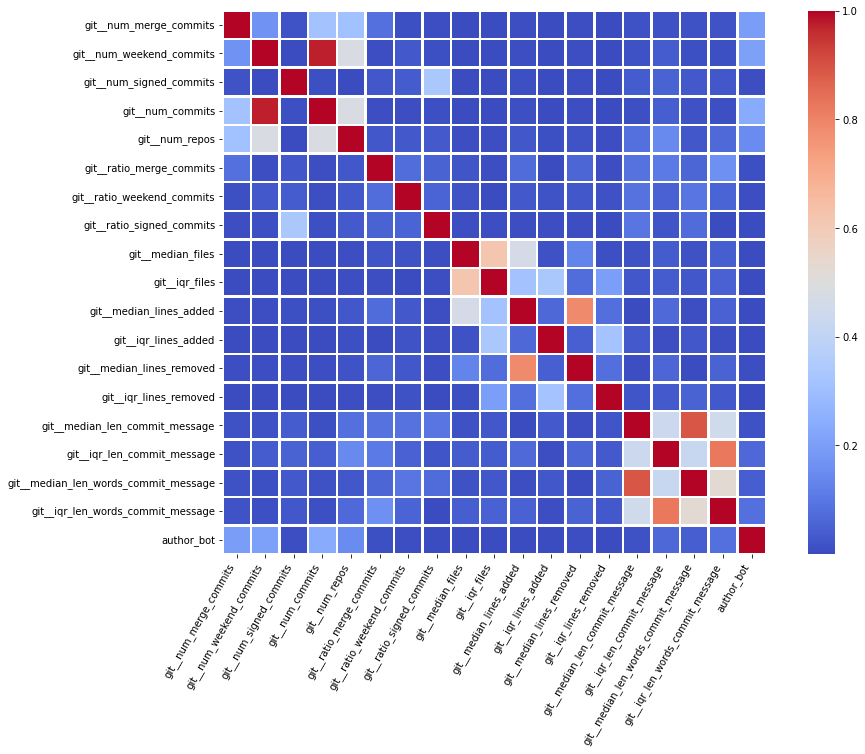

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

df_git_corr_matrix = df_git.corr().abs()
plt.figure(figsize=(15,10))
ax = sns.heatmap(
    df_git_corr_matrix,
    linewidths=1.5,
    square=True,
    xticklabels=True,
    yticklabels=True,
    cmap='coolwarm'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=60,
    horizontalalignment='right',
);

plt.savefig('docs/imgs/eda_corr_heatmap_as_is.png', dpi=600, bbox_inches='tight', pad_inches=1.5, transparent=True)

### Statistical distribution of variables

We start with our target feature: the first thing we observe is that we have a huge imbalance between the classes we aim to classify.

#### Target variable: author_bot

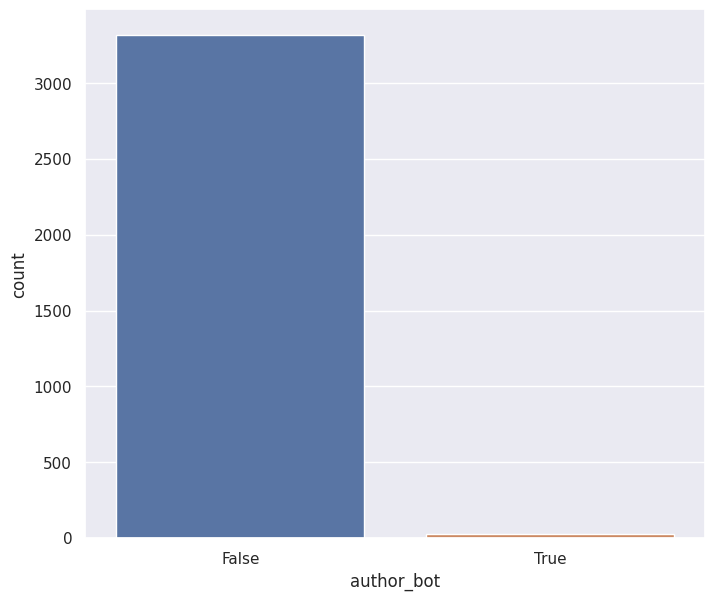

In [5]:
sns.set(style="darkgrid")

plt.figure(figsize=(8, 7), dpi=100)
sns.countplot(data=df_git, x="author_bot")
plt.show()

#### Rest of variables
Let's represent the frequency distribution of all the variables in our "Contributors dataset":

##### Group 1

|  |  |
| - | - |
| git__num_weekend_commits | git__num_merge_commits |
| git__num_signed_commits | git__num_commits |

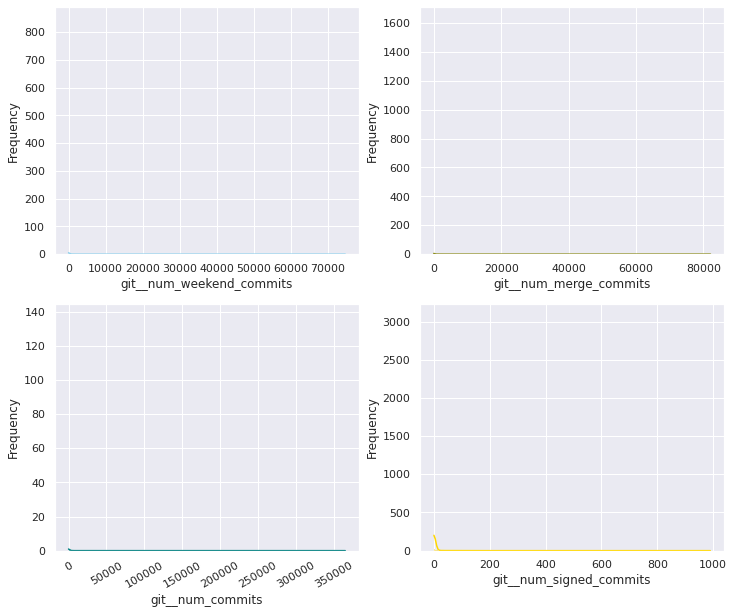

In [6]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    sns.histplot(data=df_git, x="git__num_weekend_commits", discrete=True, stat='frequency', kde=True, color="skyblue", ax=axs[0, 0])
    sns.histplot(data=df_git, x="git__num_merge_commits", discrete=True, stat='frequency', kde=True, color="olive", ax=axs[0, 1])
    sns.histplot(data=df_git, x="git__num_signed_commits", discrete=True, stat='frequency', kde=True, color="gold", ax=axs[1, 1])
    sns.histplot(data=df_git, x="git__num_commits", discrete=True, stat='frequency', kde=True, color="teal", ax=axs[1, 0]).tick_params(axis='x', labelrotation=30)

    plt.show()

---

##### Group 2


|  |  |
| - | - |
| git__ratio_weekend_commits | git__ratio_merge_commits |
| git__ratio_signed_commits | git__num_repos |

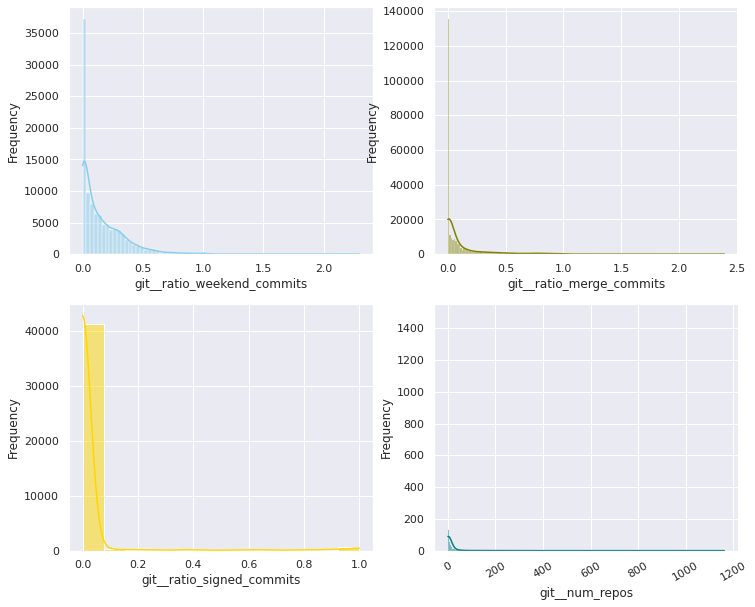

In [7]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    sns.histplot(data=df_git, x="git__ratio_weekend_commits", stat='frequency', kde=True, color="skyblue", ax=axs[0, 0])
    sns.histplot(data=df_git, x="git__ratio_merge_commits", stat='frequency', kde=True, color="olive", ax=axs[0, 1])
    sns.histplot(data=df_git, x="git__ratio_signed_commits", stat='frequency', kde=True, color="gold", ax=axs[1, 0])
    sns.histplot(data=df_git, x="git__num_repos", discrete=True, stat='frequency', kde=True, color="teal", ax=axs[1, 1]).tick_params(axis='x', labelrotation=30)

    plt.show()

---

##### Group 3

|  |  |
| - | - |
| git__median_files | git__iqr_files |
| git__median_lines_added | git__iqr_lines_added |

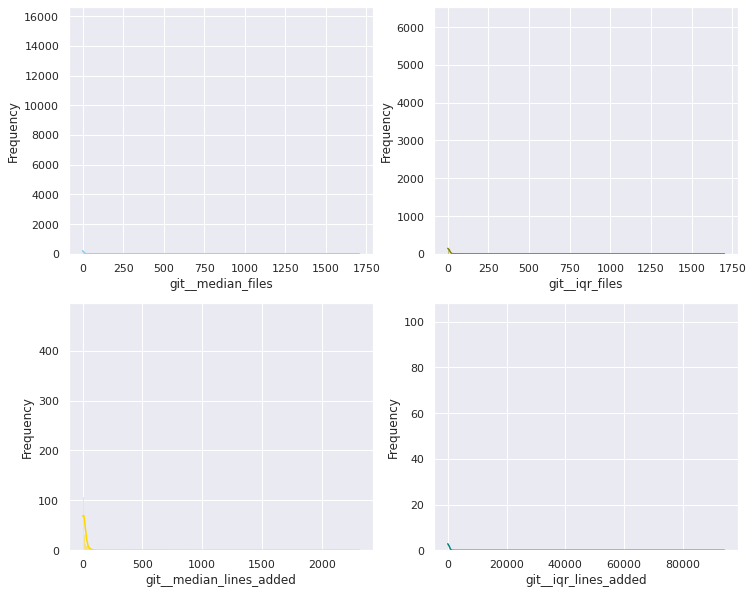

In [8]:
if REGENERATE_PLOTS:
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    sns.histplot(data=df_git, x="git__median_files", stat='frequency', kde=True, color="skyblue", ax=axs[0, 0])
    sns.histplot(data=df_git, x="git__iqr_files", stat='frequency', kde=True, color="olive", ax=axs[0, 1])
    sns.histplot(data=df_git, x="git__median_lines_added", stat='frequency', kde=True, color="gold", ax=axs[1, 0])
    sns.histplot(data=df_git, x="git__iqr_lines_added", stat='frequency', kde=True, color="teal", ax=axs[1, 1])

    plt.show()

---

##### Group 4

|  |  |
| - | - |
| git__median_lines_removed | git__iqr_lines_removed |
| git__median_len_commit_message | git__iqr_len_commit_message |

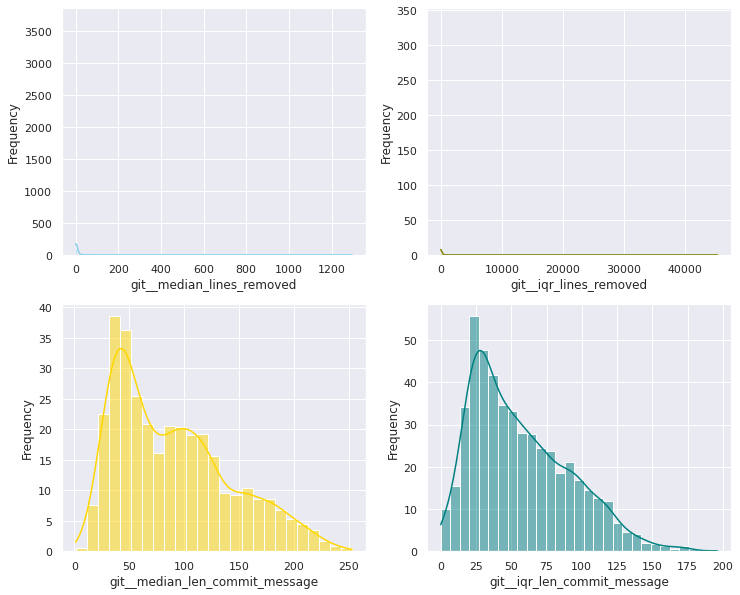

In [9]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    sns.histplot(data=df_git, x="git__median_lines_removed", stat='frequency', kde=True, color="skyblue", ax=axs[0, 0])
    sns.histplot(data=df_git, x="git__iqr_lines_removed", stat='frequency', kde=True, color="olive", ax=axs[0, 1])
    sns.histplot(data=df_git, x="git__median_len_commit_message", stat='frequency', kde=True, color="gold", ax=axs[1, 0])
    sns.histplot(data=df_git, x="git__iqr_len_commit_message", stat='frequency', kde=True, color="teal", ax=axs[1, 1])

    plt.show()

---

##### Group 5

|  |  |
| - | - |
| git__median_len_words_commit_message | git__iqr_len_words_commit_message |

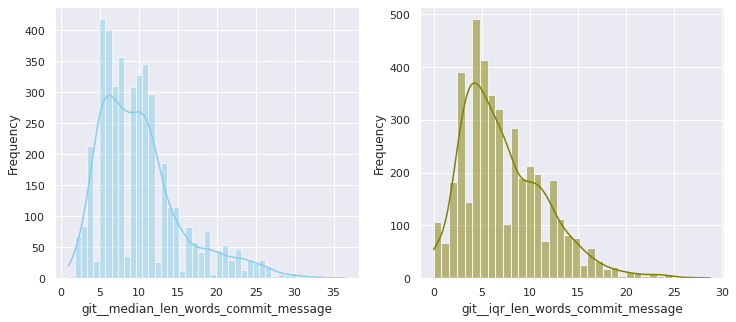

In [10]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    sns.histplot(data=df_git, x="git__median_len_words_commit_message", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=df_git, x="git__iqr_len_words_commit_message", stat='frequency', kde=True, color="olive", ax=axs[1])

    plt.show()

# Generate training, test and validation sets

The main dataset needs to be split into subsets for the classification stage: 
* one for training (60% of the samples)
* one for testing (25% of the samples)
* another one for validation (15% of the samples).

These subsets need to be statistically similar, so the sample needs to be stratified in order to keep the human/bot proportion. The method `train_test_split` from Scikit-Learn's `model_selection` module was used to obtain these subsets, by using the option `stratify`.

In [11]:
from sklearn.model_selection import train_test_split

# Separate target variable
y_git = df_git.pop('author_bot')

# Divide the Dataset into 60% training and 40% test + validation
X_train_git, X_test_tmp_git,\
y_train_git, y_test_tmp_git = train_test_split(df_git, y_git, test_size=0.4,
                                               random_state=22, stratify=y_git)

# From 40% of the original dataset, 25% is for test and 15% is for validation
# This means we have to split the test+validation set in a 62,5%/37,5% ratio

X_test_git, X_val_git,\
y_test_git, y_val_git = train_test_split(X_test_tmp_git, y_test_tmp_git,
                                         test_size=0.375, random_state=22,
                                         stratify=y_test_tmp_git)

# Pre-processing of the Training Dataset

## Detection and processing of missing data: Training dataset

The data is provided by the GrimoireLab tool set, and the dataset is a collection of information from Git commits. The fields and the information per commit are expected to be standard. 

As we are building in a later step a custom dataset summarizing information per author, we are not having missing data except for author-related information, such as the author's name, username, or email (at least one of these three variables has to have a non-empty value).

## Correlation: Training dataset

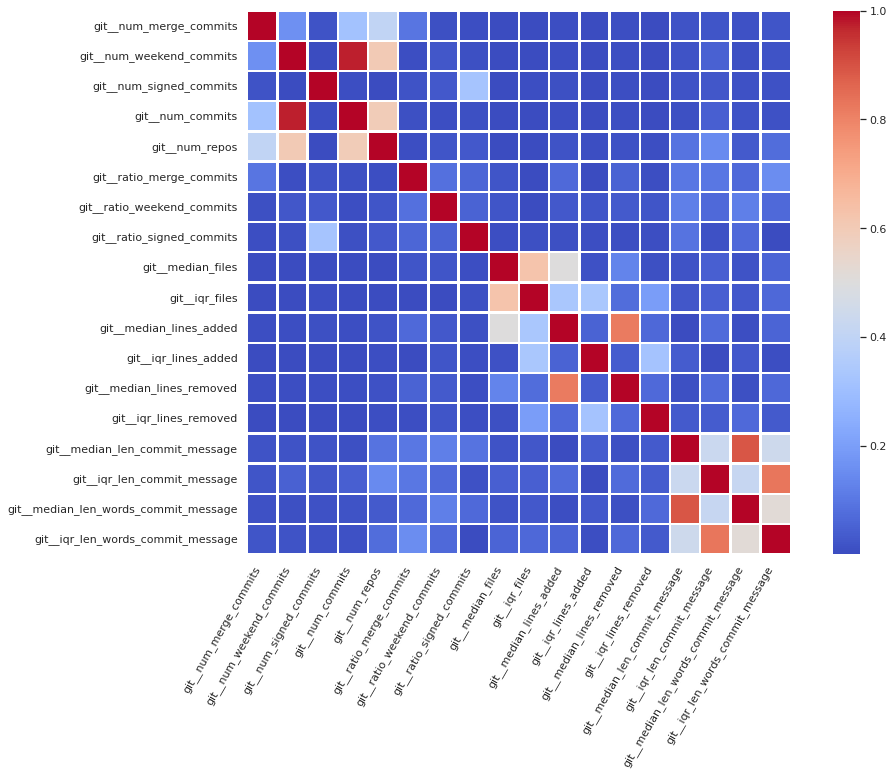

In [12]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(
    X_train_git.corr().abs(),
    linewidths=1.5,
    square=True,
    xticklabels=True,
    yticklabels=True,
    cmap='coolwarm'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=60,
    horizontalalignment='right',
);

plt.savefig('eda_corr_heatmap_before.png', dpi=600, bbox_inches='tight', pad_inches=1.5, transparent=True)

## Transformation: Quantitative variables

Most of the features from this dataset are quantitative variables, as they are representing a summary of the information obtained from the set of commits submitted by each unique author.

The first examination shows that most of these quantitative variables have remarkably uneven statistical distributions. There are huge differences in the ranges of values, and also these values are widespread. Under this situation, the approximation to take was to apply mathematical functions helping to scale these values. Although several transformations were tested, most of the variables have been transformed using a customized logarithmic function[1] or the squared root function. 

The next pairs of images show the frequency distributions of both the original variable (left) and the transformed one (right).

[1] $\mathrm{sLog_{10}}(x) = Log_{10}(1 + x)$

In [13]:
def log10(x):
    return np.log(x)

def shifted_log10(x):
    return np.log(1 + x)

### Number of commits

In [14]:
X_train_git["git__log_num_commits"] = X_train_git["git__num_commits"].apply(lambda x: log10(x))

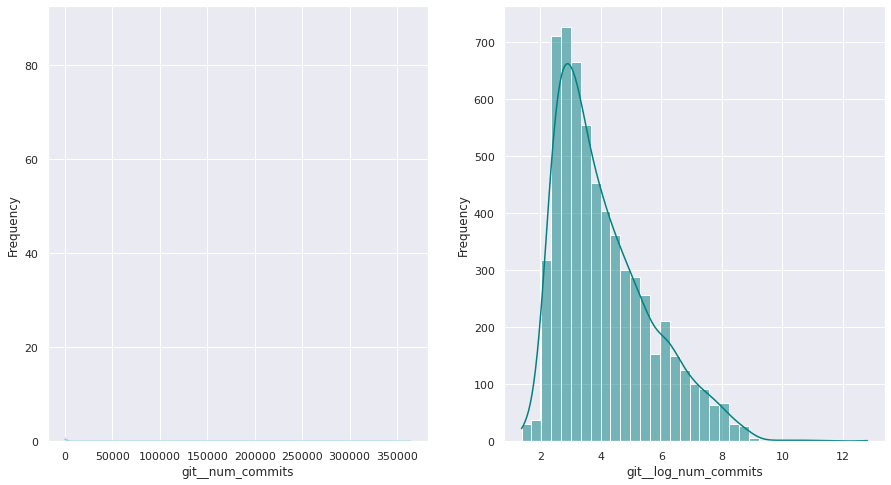

In [15]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__num_commits", stat='frequency', discrete=True, kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_num_commits", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

### Number of merge commits

In [16]:
X_train_git["git__log_num_merge_commits"] = X_train_git["git__num_merge_commits"].apply(lambda x: shifted_log10(x))

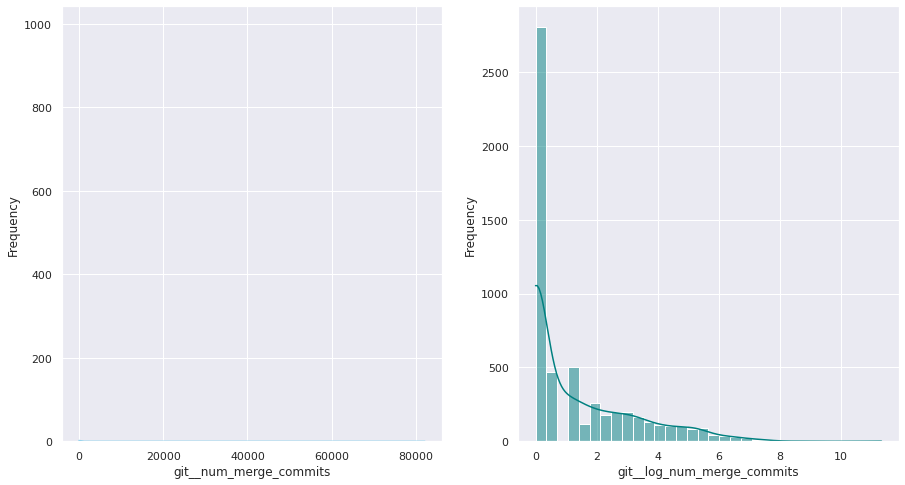

In [17]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__num_merge_commits", stat='frequency', discrete=True, kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_num_merge_commits", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

### Number of weekend commits

In [18]:
X_train_git["git__log_num_weekend_commits"] = X_train_git["git__num_weekend_commits"].apply(lambda x: shifted_log10(x))

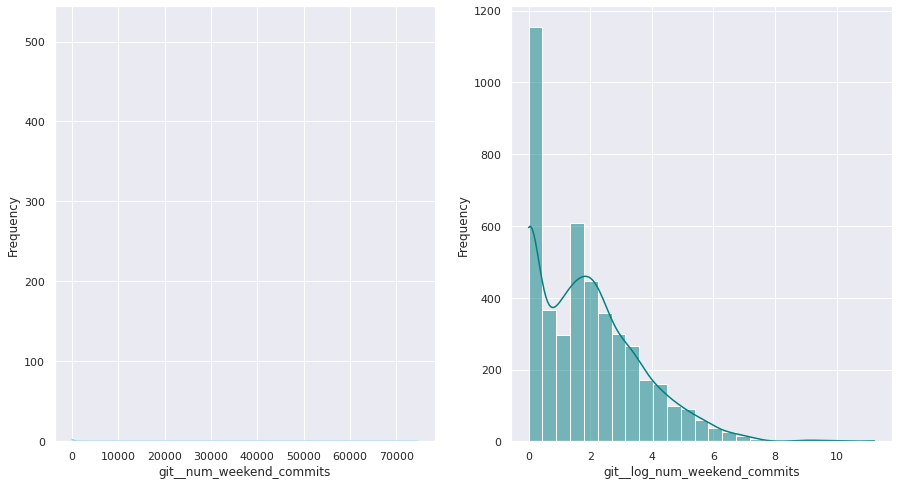

In [19]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__num_weekend_commits", stat='frequency', discrete=True, kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_num_weekend_commits", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

### Number of signed commits

In [20]:
X_train_git["git__log_num_signed_commits"] = X_train_git["git__num_signed_commits"].apply(lambda x: shifted_log10(x))

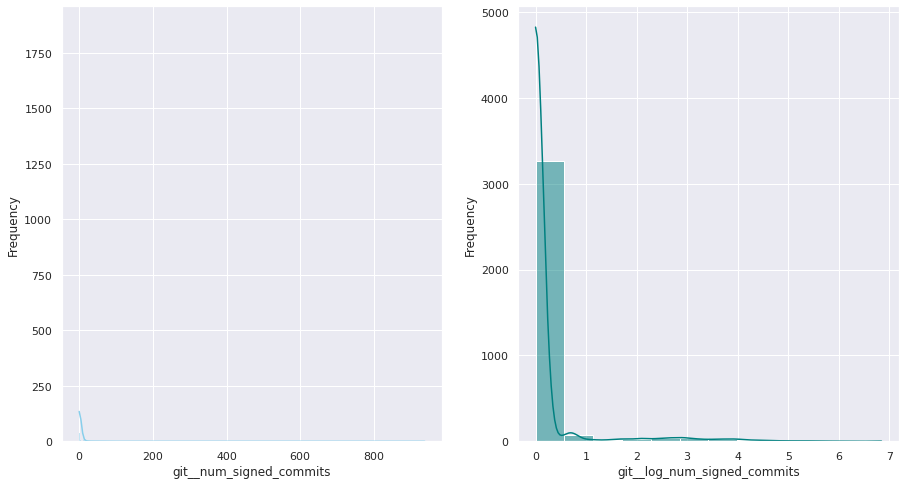

In [21]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__num_signed_commits", stat='frequency', discrete=True, kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_num_signed_commits", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

### Number of repositories

In [22]:
X_train_git["git__log_num_repos"] = X_train_git["git__num_repos"].apply(lambda x: log10(x))

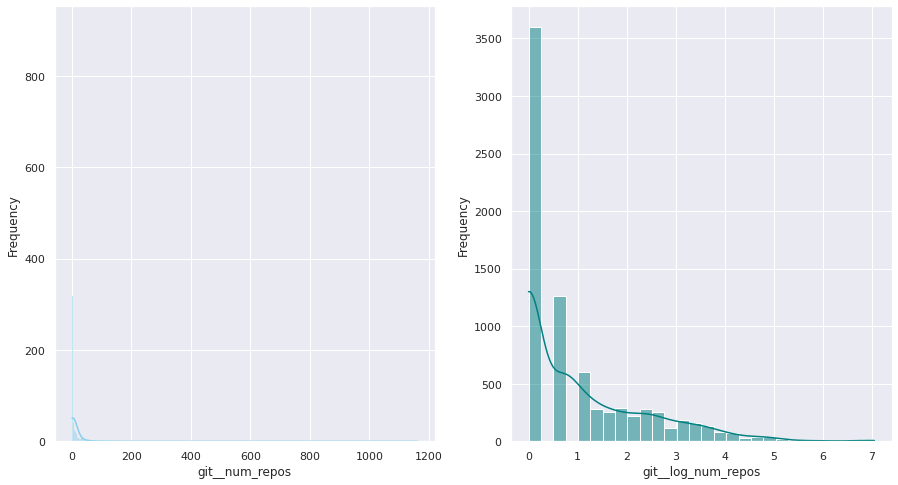

In [23]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__num_repos", stat='frequency', discrete=True, kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_num_repos", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

### Ratio of merge commits

In [24]:
X_train_git["git__sqrt_ratio_merge_commits"] = X_train_git["git__ratio_merge_commits"].apply(lambda x: np.sqrt(x))

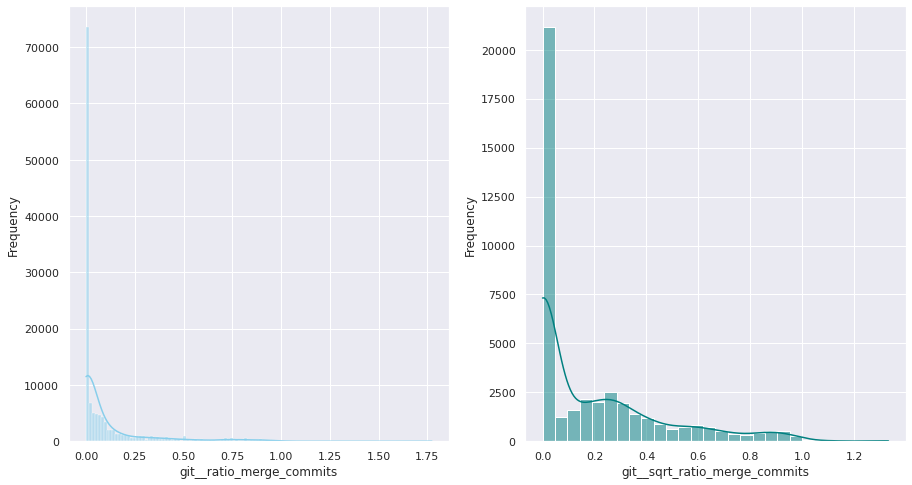

In [25]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__ratio_merge_commits", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__sqrt_ratio_merge_commits", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

### Ratio of weekend commits

In [26]:
X_train_git["git__sqrt_ratio_weekend_commits"] = X_train_git["git__ratio_weekend_commits"].apply(lambda x: np.sqrt(x))

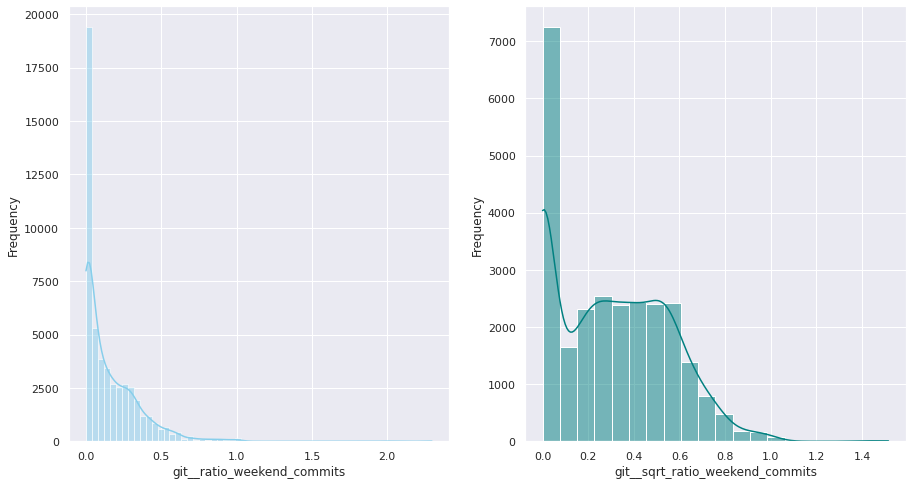

In [27]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__ratio_weekend_commits", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__sqrt_ratio_weekend_commits", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

### Ratio of signed commits

In [28]:
X_train_git["git__sqrt_ratio_signed_commits"] = X_train_git["git__ratio_signed_commits"].apply(lambda x: np.sqrt(x))

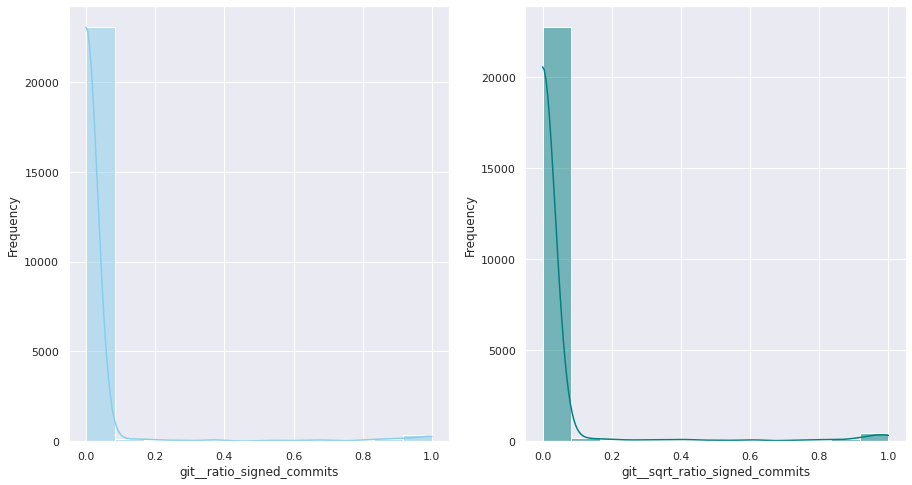

In [29]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__ratio_signed_commits", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__sqrt_ratio_signed_commits", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

### Number of files modified

#### Median

In [30]:
X_train_git["git__log_median_files"] = X_train_git["git__median_files"].apply(lambda x: shifted_log10(x))

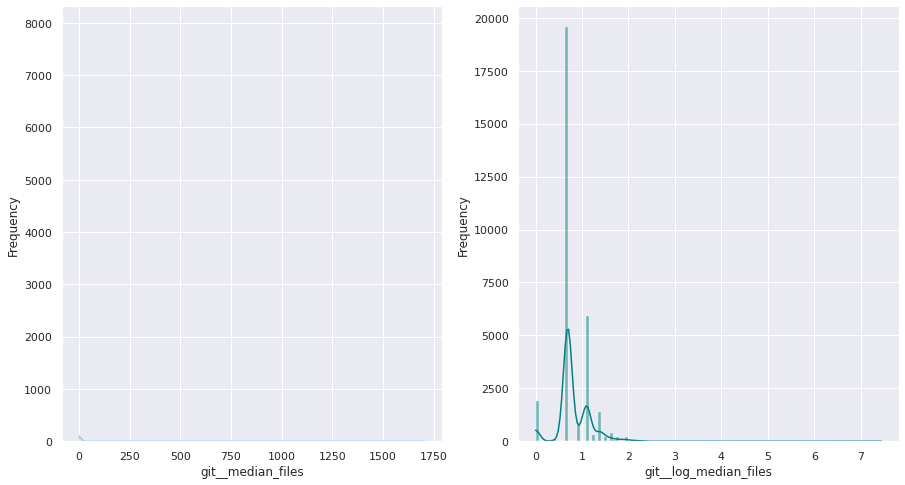

In [31]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__median_files", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_median_files", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

#### Interquartilic range

In [32]:
X_train_git["git__log_iqr_files"] = X_train_git["git__iqr_files"].apply(lambda x: shifted_log10(x))

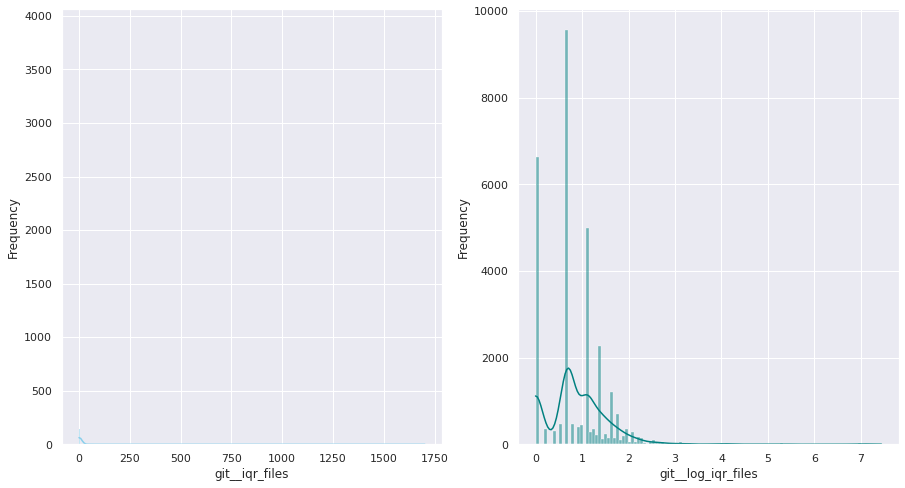

In [33]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__iqr_files", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_iqr_files", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

### Number of lines added

#### Median

In [34]:
X_train_git["git__log_median_lines_added"] = X_train_git["git__median_lines_added"].apply(lambda x: shifted_log10(x))

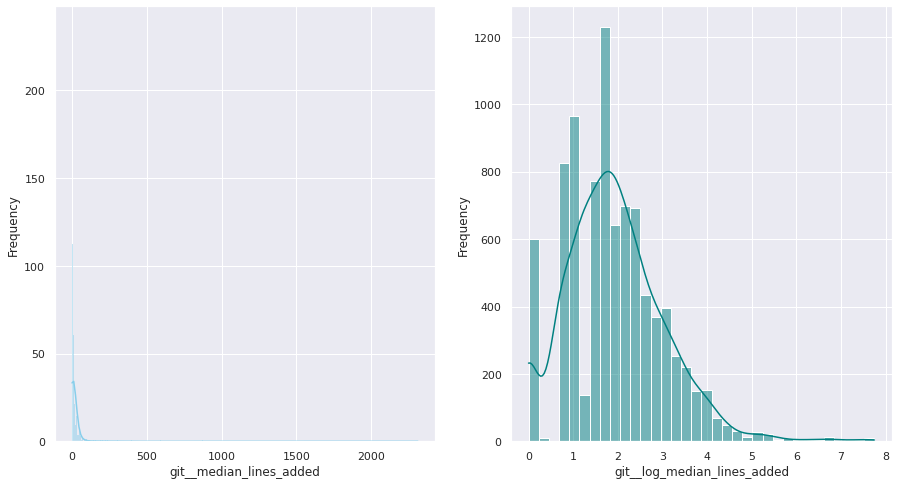

In [35]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__median_lines_added", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_median_lines_added", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

#### Interquartilic range

In [36]:
X_train_git["git__log_iqr_lines_added"] = X_train_git["git__iqr_lines_added"].apply(lambda x: shifted_log10(x))

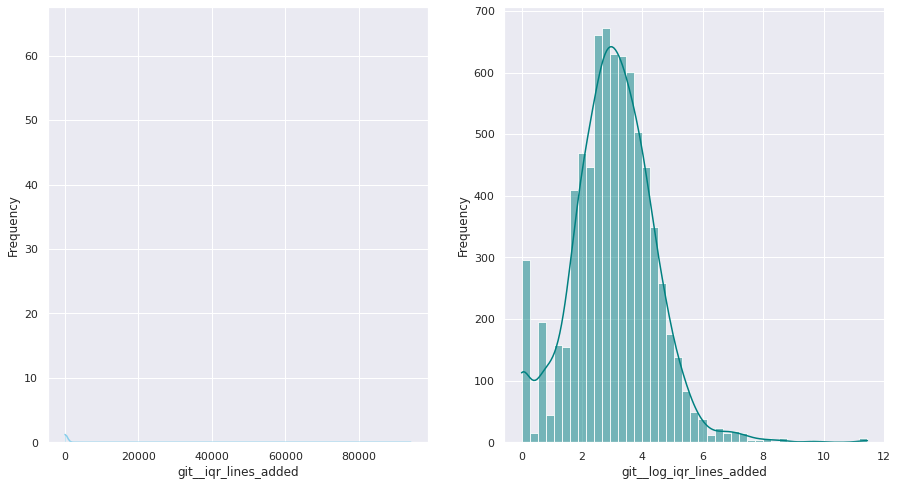

In [37]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__iqr_lines_added", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_iqr_lines_added", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

### Number of lines removed

#### Median

In [38]:
X_train_git["git__log_median_lines_removed"] = X_train_git["git__median_lines_removed"].apply(lambda x: shifted_log10(x))

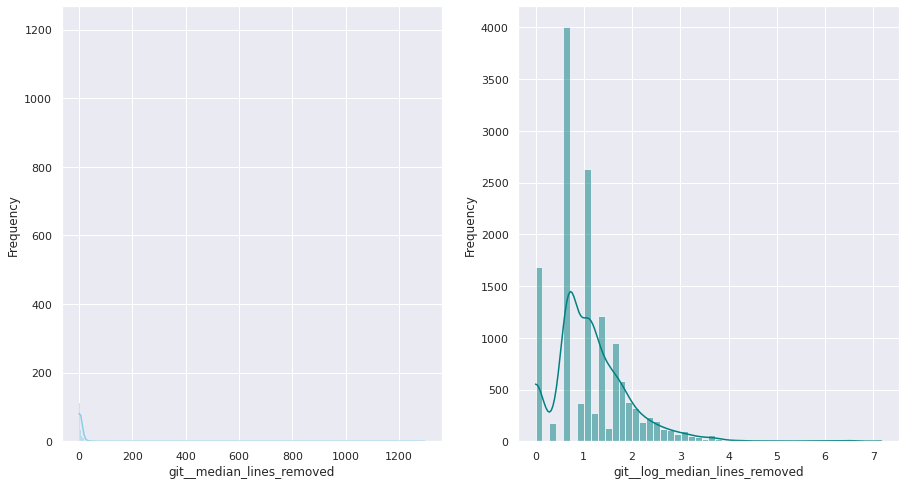

In [39]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__median_lines_removed", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_median_lines_removed", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

#### Interquartilic range

In [40]:
X_train_git["git__log_iqr_lines_removed"] = X_train_git["git__iqr_lines_removed"].apply(lambda x: shifted_log10(x))

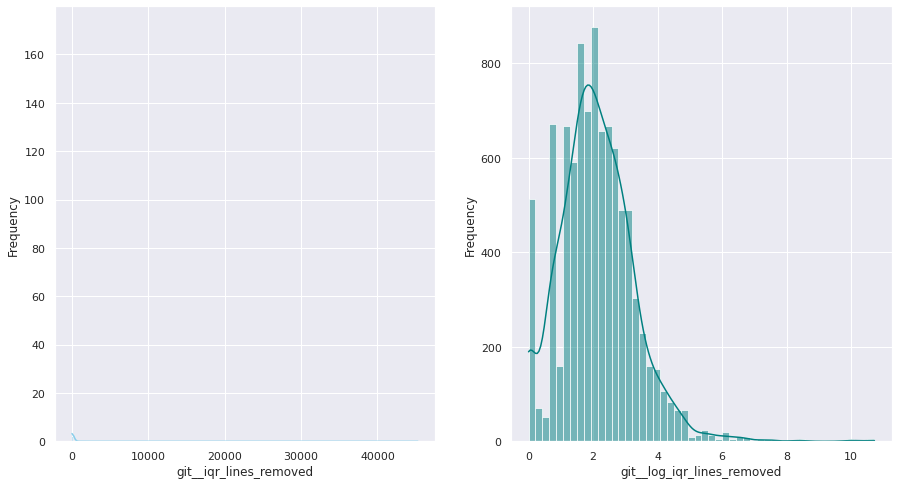

In [41]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__iqr_lines_removed", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_iqr_lines_removed", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

### Length of commit message

#### Median

In [42]:
X_train_git["git__log_median_len_commit_message"] = X_train_git["git__median_len_commit_message"].apply(lambda x: shifted_log10(x))

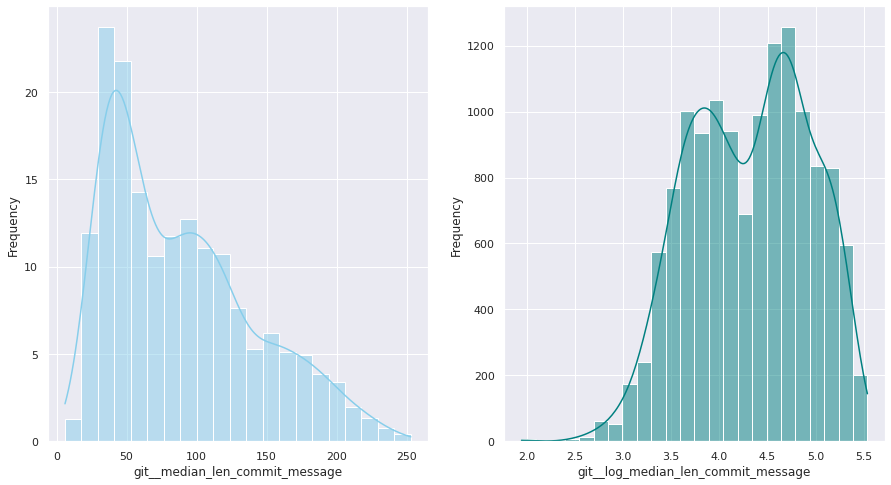

In [43]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__median_len_commit_message", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_median_len_commit_message", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

#### Interquartilic range

In [44]:
X_train_git["git__log_iqr_len_commit_message"] = X_train_git["git__iqr_len_commit_message"].apply(lambda x: shifted_log10(x))

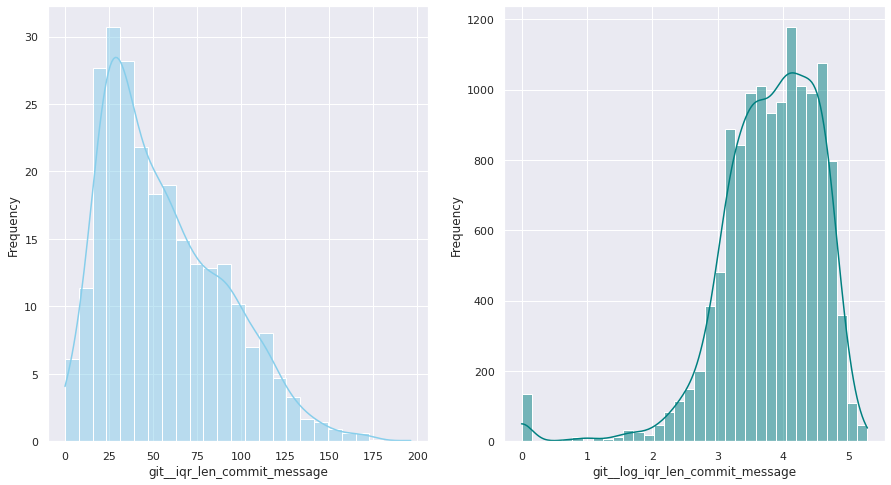

In [45]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__iqr_len_commit_message", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_iqr_len_commit_message", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

### Length of commit message, number of words

#### Median

In [46]:
X_train_git["git__log_median_len_words_commit_message"] = X_train_git["git__median_len_words_commit_message"].apply(lambda x: shifted_log10(x))

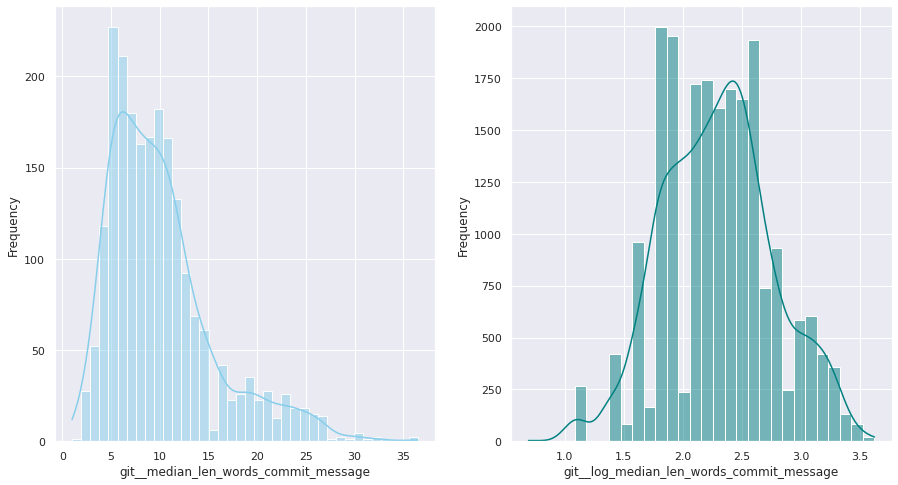

In [47]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__median_len_words_commit_message", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_median_len_words_commit_message", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

#### Interquartilic range

In [48]:
X_train_git["git__log_iqr_len_words_commit_message"] = X_train_git["git__iqr_len_words_commit_message"].apply(lambda x: shifted_log10(x))

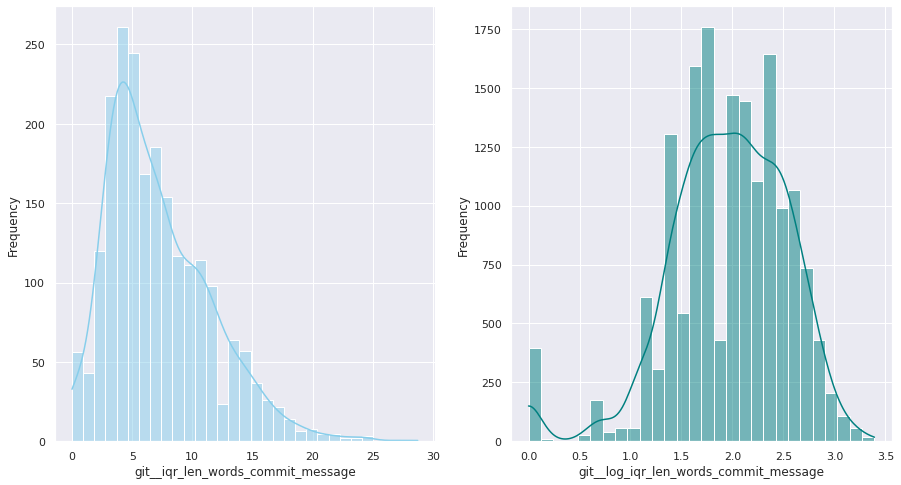

In [49]:
if REGENERATE_PLOTS:
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    sns.histplot(data=X_train_git, x="git__iqr_len_words_commit_message", stat='frequency', kde=True, color="skyblue", ax=axs[0])
    sns.histplot(data=X_train_git, x="git__log_iqr_len_words_commit_message", stat='frequency', kde=True, color="teal", ax=axs[1])

    plt.show()

## Transformation: Cualitative variables

Most of the variables from this data-set are quantitative. Nonetheless, the statistical distribution of some of them points a need to generate qualitative, binary variables derived from them.
These variables have a high bias. Looking at the statistical distribution, the general rule is observing a high peak in "0" value and then the rest of the results are spread over the histogram. 

For this reason, these variables are transformed into binary variables. This transformation also makes sense in a conceptual way. For instance, looking at the number of merge commits, instead of counting how many of them there are, it is more meaningful knowing if a given author submitted merge commits or not.

The variables transformed into binary are:

| Former field | Transformed field | Meaning |
| ------------ | ----------------- | ------- |
| `git__num_merge_commits` | `git__has_merge_commits` | "1" if a given author has submitted at least 1 merge commit. "0" otherwise |
| `git__num_weekend_commits` | `git__has_weekend_commits` | "1" if a given author has submitted at least 1 commit during weekends (Saturday or Sunday). "0" otherwise |
| `git__num_signed_commits` | `git__has_signed_commits` | "1" if a given author has submitted at least 1 signed commit. "0" otherwise |
| `git__median_lines_added` | `git__mostly_not_adding_lines` | "1" if the median of added lines for that author is "0" (this author is not adding lines in at least 50% of the commits), "0" otherwise |
| `git__median_lines_removed` | `git__mostly_not_removing_lines` | "1" if the median of removed lines for that author is "0" (this author is not removing lines in at least 50% of the commits), "0" otherwise |


### Heuristic terms

The heuristic terms in the table belong to the application domain, using terminology of the tasks the bots are usually performing in software repositories. With these terms, a set of dummy variables is created with one column per term, where the value is "1" (**True**) when the term from that column is included in the author's name; and "0" (**False**) if is not included. For instance, a user named `ghmerger` would have a "1" value in the `merge` and `merger` columns, and a "0" value in the rest of the columns.

Additionaly, there is another binary variable summarizing if the author name contains any of these terms: `git__author_name_has_term`.

| Heuristic terms |
| --------------- |
| `auto`, `bot`, `build`, `cd`, `ci`, `code`, `commit`, `copy`, `dependency`, |
| `fix`, `integration`, `issue`, `merge`, `patrol`, `pr`, `pull`, |
| `release`, `request`, `review`, `sync`, `template`, `tool`, `travis`|
  
  
Nonetheless, this approach was adding too much complexity to the system. After several experiments, the decision was to summarize the inclusion of these terms into a "terms score". The idea was to classify the heuristic terms in three different levels assigning weights to each of them, according to their relevance in the application domain. Doing so, an author name having one or more terms from the list would have a greater value, also taking into account their relevance by using these levels. Having a score of `0` means the `author_name` field doesn't include any of the relevant terms. 

* The definition of these three levels is:

| Level | Terms |
| ----- | ----- |
| 1 | `bot`, `dependency`, `fix`, `integration`, `merge` |
| 2 | `auto`, `build`, `commit`, `copy`, `issue`, `release`, `request`, `review`, `sync`, `template`, `tool`, `travis` |
| 3 | `cd`, `ci`, `code`, `patrol`, `pr`, `pull` |

* The formula to compute this terms score is: ${Ts}(term) = 60Nl_{1} + 30Nl_{2} + 10Nl_{3}$.


In [50]:
heuristic_terms = ['bot', 'ci', 'cd', 'build', 'auto', 'travis', 'copy',
                   'dependency', 'fix', 'merge', 'template', 'sync',
                   'integration', 'release', 'code', 'review', 'tool',
                   'patrol', 'issue', 'pr', 'pull', 'request', 'commit']

terms_l1 = ['bot', 'dependency', 'fix', 'integration', 'merge']
terms_l2 = ['auto', 'build', 'commit', 'copy', 'issue', 'release',
            'request', 'review', 'sync', 'template', 'tool', 'travis']
terms_l3 = ['cd', 'ci', 'code', 'patrol', 'pr', 'pull']

def compute_terms_score(x, terms):
    score = 0
    n_l1 = 0
    n_l2 = 0
    n_l3 = 0
    for term in terms:
        if term.lower() in x.lower():
            if term in terms_l1:
                n_l1 += 1
            elif term in terms_l2:
                n_l2 += 1
            elif term in terms_l3:
                n_l3 += 1
    score = 60*n_l1 + 30*n_l2 + 10*n_l3
    # norm_score = (100*score)/720
    return score

def str_has_heuristic(x, terms):
    for term in terms:
        if term in x:
            return 1
    return 0

def produce_dummy_terms(author_name, terms):
    list_terms = []
    for term in terms:
        value = 0
        term = str(term)
        author_name = str(author_name)
        if term.lower() in author_name.lower():
            value = 1
        list_terms.append(value)
    return pd.Series(list_terms)


In [51]:
vars_subset = ['git__log_num_commits',
               'git__log_num_merge_commits',
               'git__log_num_weekend_commits',
               'git__log_num_signed_commits',
               'git__log_num_repos',
               'git__sqrt_ratio_merge_commits',
               'git__sqrt_ratio_weekend_commits',
               'git__sqrt_ratio_signed_commits',
               'git__log_median_files',
               'git__log_iqr_files',
               'git__log_median_lines_added',
               'git__log_iqr_lines_added',
               'git__log_median_lines_removed',
               'git__log_iqr_lines_removed',
               'git__log_median_len_commit_message',
               'git__log_iqr_len_commit_message',
               'git__log_median_len_words_commit_message',
               'git__log_iqr_len_words_commit_message']


X_train_git['git__has_merge_commits'] = (X_train_git['git__num_merge_commits'] > 0).astype(int)
X_train_git['git__has_weekend_commits'] = (X_train_git['git__num_weekend_commits'] > 0).astype(int)
X_train_git['git__has_signed_commits'] = (X_train_git['git__num_signed_commits'] > 0).astype(int)

X_train_git['terms_score'] = X_train_git['author_name'].apply(lambda x: compute_terms_score(x, heuristic_terms))
vars_subset += ['terms_score']

X_train_git['git__mostly_not_adding_lines'] = (X_train_git['git__median_lines_added'] == 0).astype(int)
X_train_git['git__mostly_not_removing_lines'] = (X_train_git['git__median_lines_removed'] == 0).astype(int)
vars_subset += ['git__has_merge_commits',
                'git__has_weekend_commits',
                'git__has_signed_commits',
                'git__mostly_not_adding_lines',
                'git__mostly_not_removing_lines']

In [52]:
X_train_git["log_terms_score"] = X_train_git["terms_score"].apply(lambda x: shifted_log10(x))

Let's represent the frequncy distribution of the new "Terms score" variable and test how it looks like when it is transfomed. As we are interested in having a variable representing a wide range of values, we decided not to normalise the value nor transform it. 

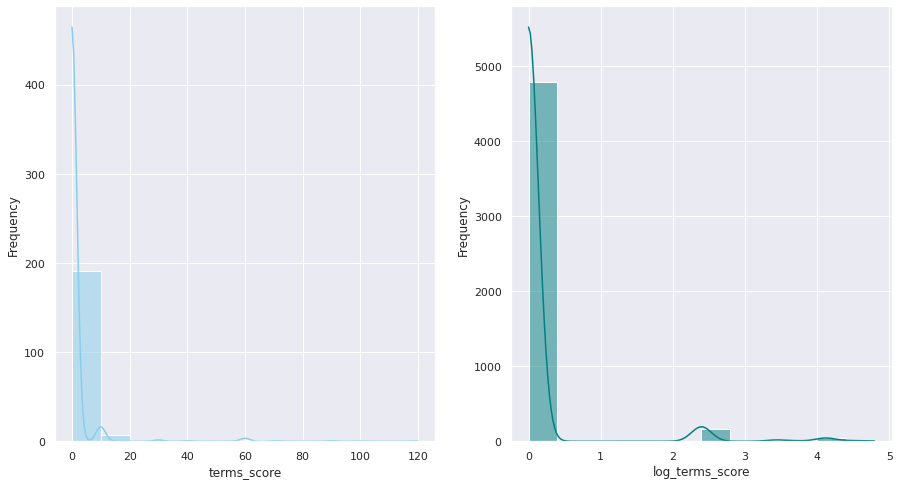

In [53]:
# Represent the frequncy distribution of the new "Terms score" variable
# and test how it looks like when it is transfomed. 
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

sns.histplot(data=X_train_git, x="terms_score", stat='frequency', kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=X_train_git, x="log_terms_score", stat='frequency', kde=True, color="teal", ax=axs[1])

plt.show()

## Correlation after transforming the variables

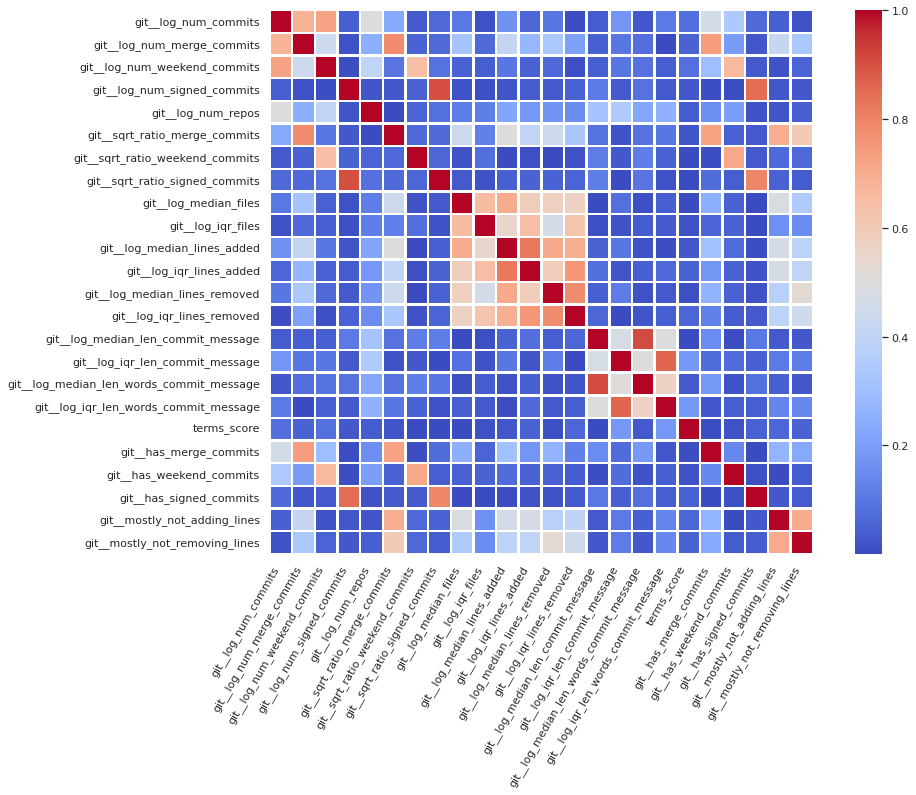

In [54]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(
    X_train_git[vars_subset].corr().abs(),
    linewidths=1.5,
    square=True,
    xticklabels=True,
    yticklabels=True,
    cmap='coolwarm'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=60,
    horizontalalignment='right',
);

plt.savefig('docs/imgs/eda_corr_heatmap_after.png', dpi=600, bbox_inches='tight', pad_inches=1.5, transparent=True)

Here we represent the variables having absolute correlation values greater than 0.75:

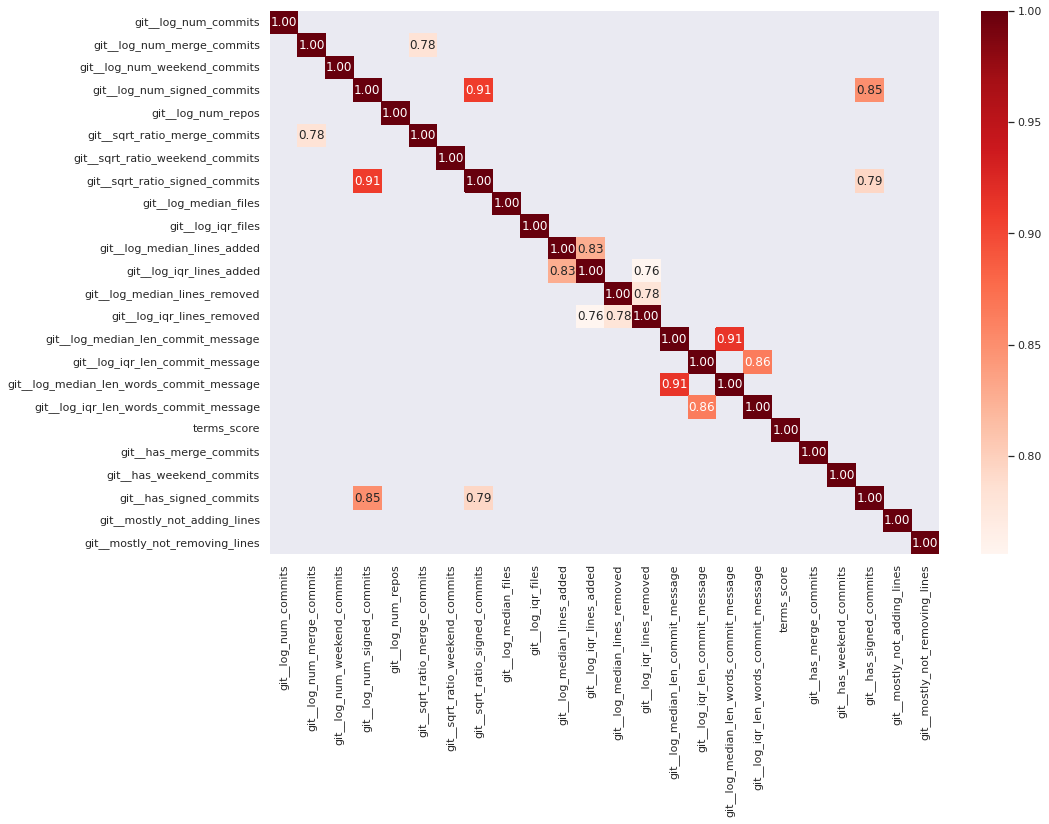

In [55]:
dfcorr = X_train_git[vars_subset].corr().abs()

kot = dfcorr[dfcorr>=.75]
plt.figure(figsize=(15, 10))
sns.heatmap(kot, cmap="Reds", annot=True, fmt=".2f")

plt.savefig('docs/imgs/eda_corr_heatmap_more_75.png', dpi=600, bbox_inches='tight', pad_inches=1.5, transparent=True)

In [56]:
# Dropping variables with higher correlation

drop_cols = [
    'git__sqrt_ratio_merge_commits',
    'git__sqrt_ratio_weekend_commits',
    'git__sqrt_ratio_signed_commits',
    'git__log_iqr_lines_added',
    'git__log_iqr_lines_removed',
    'git__log_iqr_len_commit_message',
    'git__log_median_len_words_commit_message',
    'git__has_merge_commits',
    'git__has_weekend_commits',
    'git__has_signed_commits',
    'git__mostly_not_adding_lines',
    'git__mostly_not_removing_lines',
]
X_train_git = X_train_git[vars_subset].drop(columns=drop_cols)

After removing the variables with higher correlation, this is how the ultimate correlation matrix looks like:

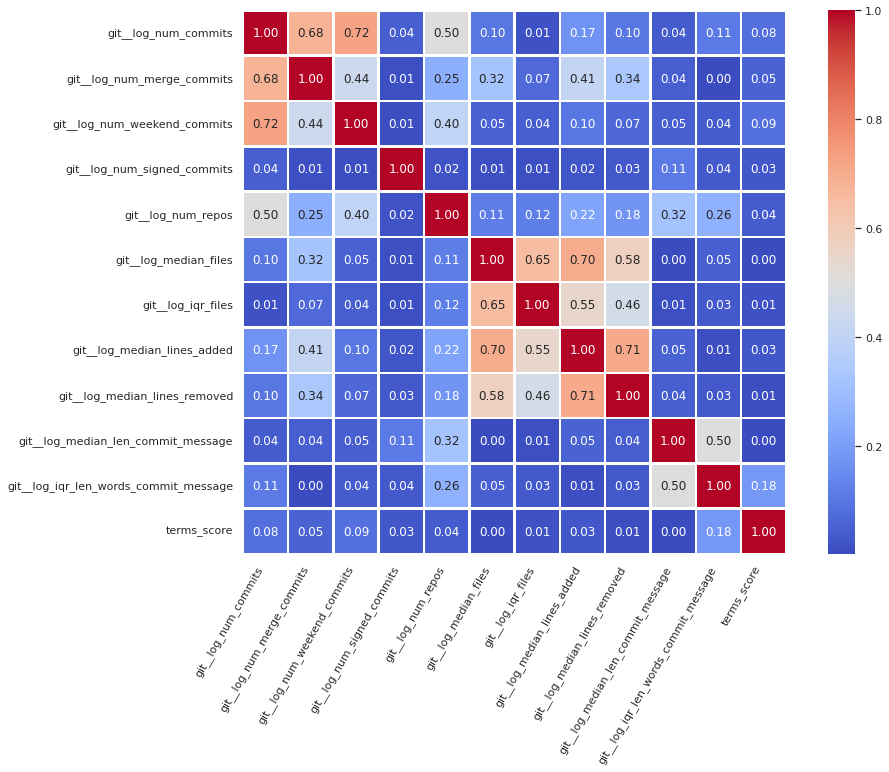

In [57]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(
    X_train_git.corr().abs(),
    linewidths=1.5,
    square=True,
    xticklabels=True,
    yticklabels=True,
    cmap='coolwarm',
    annot=True,
    fmt=".2f"
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=60,
    horizontalalignment='right',
);

plt.savefig('eda_corr_heatmap_correlation_fixed.png', dpi=600, bbox_inches='tight', pad_inches=1.5, transparent=True)

We can run an additional check to confirm that there are no pairs of variables having correlation values above 0.75:

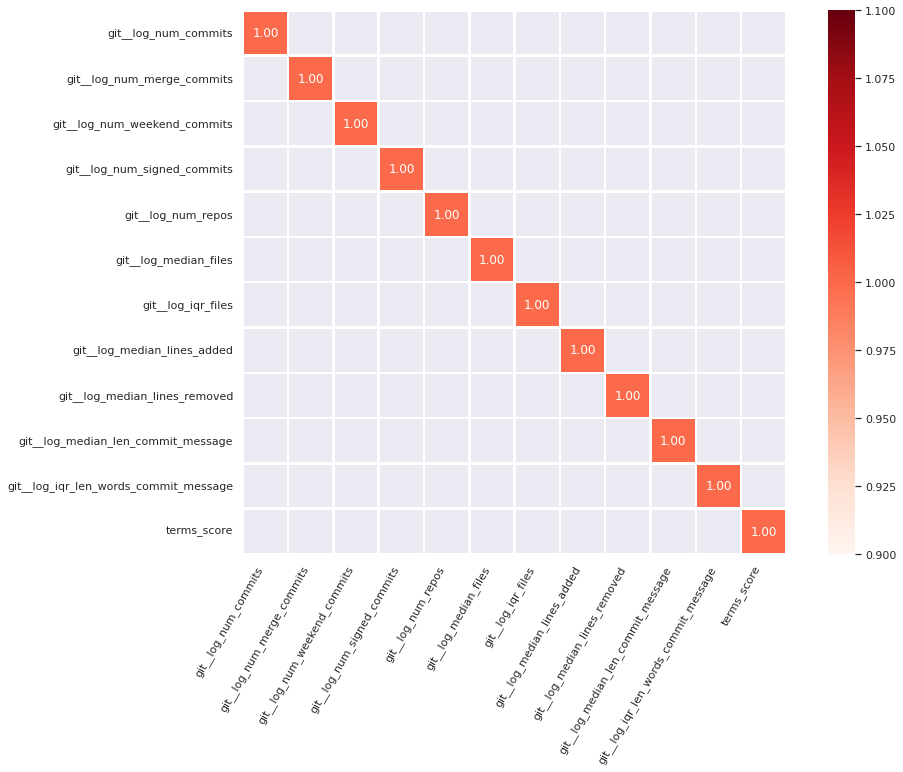

In [58]:
dfcorr2 = X_train_git.corr().abs()

kot = dfcorr2[dfcorr2>=.75]
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    kot,
    linewidths=1.5,
    square=True,
    xticklabels=True,
    yticklabels=True,
    cmap='Reds',
    annot=True,
    fmt=".2f"
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=60,
    horizontalalignment='right',
);

plt.savefig('eda_corr_heatmap_more_75_fixed.png', dpi=600, bbox_inches='tight', pad_inches=1.5, transparent=True)

## Imbalanced data

One of the main challenges of this classification is the imbalance in the target class we are aiming to detect. This context was taken into account when splitting the main dataset into the training, test, and validation tests, but it needs another processing stage before they feed the different classification models. Looking at the techniques that are commonly used to reduce the effect of imbalanced data, the one selected was **SMOTE**.

SMOTE consists of an algorithm generating new samples considering the k-nearest neighbors from each original sample from the **training set**. Each newly generated sample is interpolated between the original sample and one of the nearest neighbors; with a random component $\lambda$, which takes value in the range $[0, 1]$.

To apply SMOTE, we rely on the implementation under the `over_sampling` module from the Python library `imblearn`.

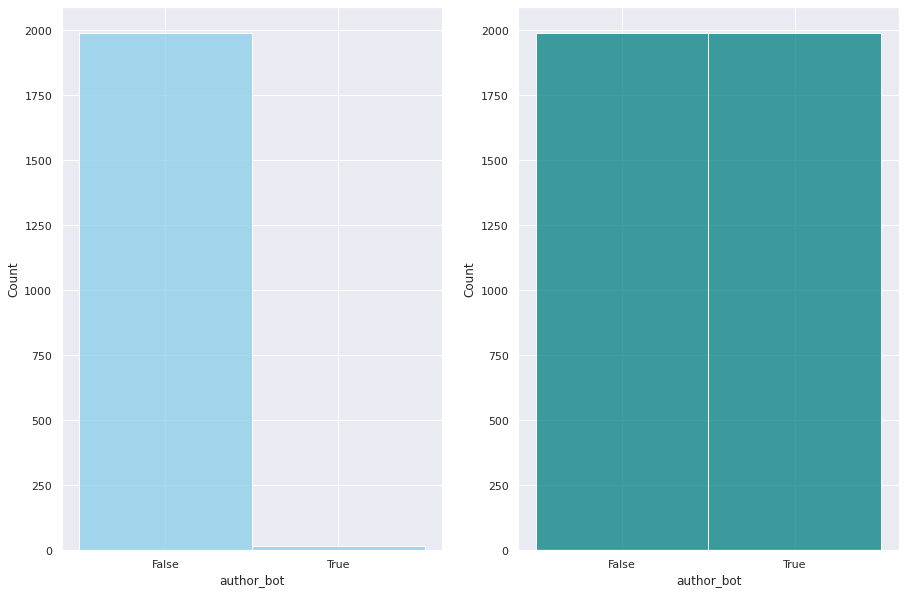

In [59]:
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state=22)
X_train_git_SMOTE, y_train_git_SMOTE = smt.fit_resample(X_train_git, y_train_git)

fig, axs = plt.subplots(1, 2, figsize=(15,10))

sns.histplot(data=y_train_git.replace({0: 'False', 1: 'True'}), stat='count', kde=False, color="skyblue", ax=axs[0])
sns.histplot(data=y_train_git_SMOTE.replace({0: 'False', 1: 'True'}), stat='count', kde=False, discrete=True, color="teal", ax=axs[1])

plt.show()

In [60]:
%%javascript
 IPython.OutputArea.prototype._should_scroll = function(lines) {
     return false;
 }

<IPython.core.display.Javascript object>